In [25]:
import torch 
import torch.nn as nn
import requests
import zipfile
from pathlib import Path
import os 
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
from torchvision import datasets,transforms,models
from torch.utils.data import DataLoader,Dataset

In [2]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Setup the Dataset


In [6]:
data_path=Path("data/")
image_path=data_path/"pizza_steak_sushi"
if image_path.is_dir():
    print(f"{image_path} already exists")
else:
    image_path.mkdir(parents=True,exist_ok=True)
    with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip",'w') as zf:
        request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip")

data\pizza_steak_sushi already exists


### Data exploration 


In [9]:
def walk_through_dir(dir_path):
    for dirpath,dirnames,filenames in os.walk(dir_path):
        print(f"there are {len(dirnames)} directors and {len(filenames)} files in {dirpath}")

walk_through_dir(image_path)

there are 2 directors and 0 files in data\pizza_steak_sushi
there are 3 directors and 0 files in data\pizza_steak_sushi\test
there are 0 directors and 25 files in data\pizza_steak_sushi\test\pizza
there are 0 directors and 19 files in data\pizza_steak_sushi\test\steak
there are 0 directors and 31 files in data\pizza_steak_sushi\test\sushi
there are 3 directors and 0 files in data\pizza_steak_sushi\train
there are 0 directors and 78 files in data\pizza_steak_sushi\train\pizza
there are 0 directors and 75 files in data\pizza_steak_sushi\train\steak
there are 0 directors and 72 files in data\pizza_steak_sushi\train\sushi


### Setup training and test path 


In [10]:
train_dir= image_path /"train"
test_dir= image_path /"test"    
print(f"there are {len(os.listdir(train_dir))} classes in the training directory")
print(f"there are {len(os.listdir(test_dir))} classes in the test directory")

there are 3 classes in the training directory
there are 3 classes in the test directory


### Visualize the data 

random image path:data\pizza_steak_sushi\test\sushi\2394442.jpg and class is :sushi


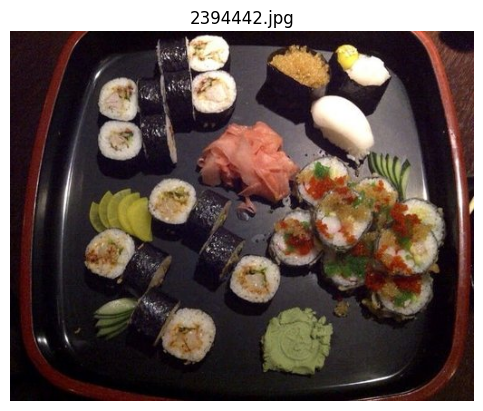

 random image path : data\pizza_steak_sushi\test\sushi\2394442.jpg and class is : sushi


In [24]:
random .seed(42)
#get a random image path
image_path_list=list(image_path.glob("*/*/*.jpg"))
#print(image_path_list)
random_image_path=random.choice(image_path_list)
image_class=random_image_path.parent.stem
print(f"random image path:{random_image_path} and class is :{image_class}")
#open the image and plot it
img=Image.open(random_image_path)   
#print(img)
plt.imshow(img)
plt.axis(False)
plt.title(random_image_path.name)
plt.show()
print (f" random image path : {random_image_path} and class is : {image_class}")


(np.float64(-0.5), np.float64(511.5), np.float64(407.5), np.float64(-0.5))

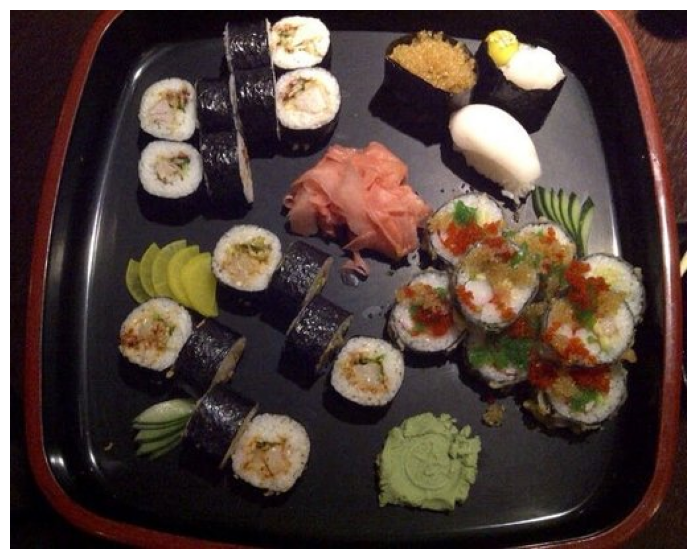

In [29]:
img_as_array=np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.axis(False)

#print(f"image as array : {img_as_array} and shape is : {img_as_array.shape}")

### TuRn ALl IMAGES InTo Tensors

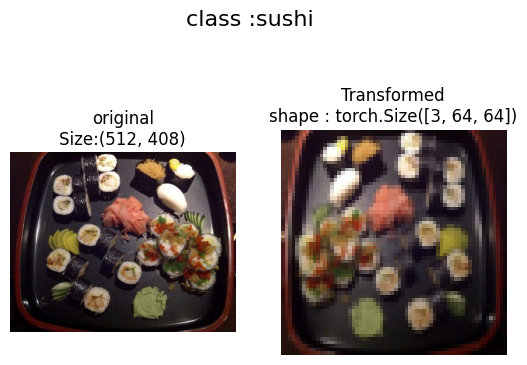

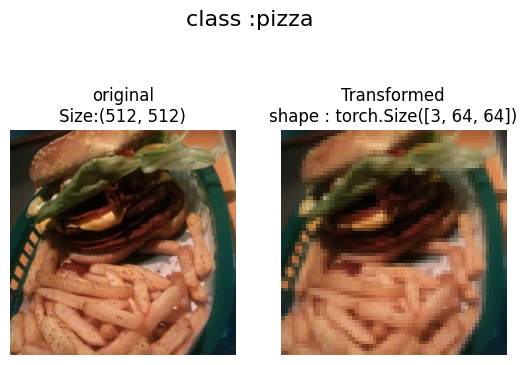

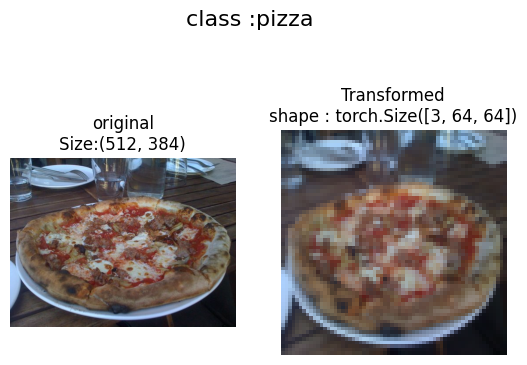

In [39]:
data_transform=transforms.Compose([# Resize the image 
                                    transforms.Resize(size=(64,64)),
                                    #flip the image randomly on the horizontal axis
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    #convert the image to a tensor
                                    transforms.ToTensor()
                                    ])
def plot_transformed_images (image_paths:list,transform,n=3,seed=None):
    if seed :
        random.seed(seed)
    random_image_paths= random.sample(image_paths,k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax =plt.subplots(nrows=1,ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"original\nSize:{f.size}")
            ax[0].axis("off")
    # Transform the image
            transformed_image=transform(f)
            #ax[1].imshow(transformed_image)
            ax[1].imshow(transformed_image.permute(1, 2, 0))
            ax[1].set_title(f"Transformed\nshape : {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"class :{image_path.parent.stem}",fontsize=16)

plot_transformed_images(image_path_list,data_transform,n=3,seed=42)